### **Complete Implementation of Spectral Clustering**

In [115]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn import preprocessing
from subprocess import check_output

In [116]:
original_data = pd.read_csv('data.csv')
original_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Cleaning, Scaling and Creating 2D Visualization for effective clustering

In [117]:
# Cleaning and modifying the data
original_data = original_data.drop('id',axis=1)
original_data = original_data.drop('Unnamed: 32',axis=1)

# Mapping Benign to 0 and Malignant to 1 
original_data['diagnosis'] = original_data['diagnosis'].map({'M':1,'B':0})

# Scaling the dataset
datas = pd.DataFrame(preprocessing.scale(original_data.iloc[:,1:32]))
datas.columns = list(original_data.iloc[:,1:32].columns)
datas['diagnosis'] = original_data['diagnosis']

# Creating the high dimensional feature space X
data_drop = datas.drop('diagnosis',axis=1)
X = data_drop.values

#Creating a 2D visualization to visualize the clusters
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=40, n_iter= 4000)
Y = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.173897
[t-SNE] KL divergence after 2200 iterations: 0.864980


Defining the K-means Function for KMeans clustering

In [118]:
def my_kmeans(data, num_clusters, max_iterations=100):
    # Initializing centroids randomly
    cluster_centers = data[np.random.choice(range(len(data)), num_clusters)]
    
    for iter in range(max_iterations):
        # Assigning each point to the nearest centroid
        distance = np.sqrt(((data - cluster_centers[:, np.newaxis])**2).sum(axis=2))
        cluster_labels = np.argmin(distance, axis=0)
        
        # Updating centroids to be the mean of the points assigned to them
        for i in range(num_clusters):
            cluster_centers[i] = data[cluster_labels == i].mean(axis=0)
    
    return cluster_labels, cluster_centers


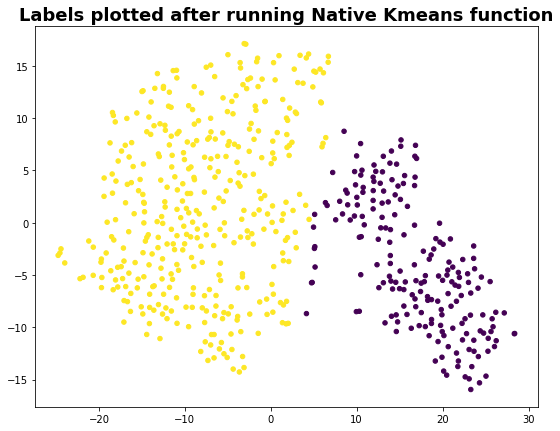

In [119]:
labels, centroids = my_kmeans(Y,2)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Labels plotted after running Native Kmeans function', fontsize=18, fontweight='demi')
ax.scatter(Y[:, 0], Y[:, 1],c=labels ,s=20)

In [120]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score
nmi_score_km = normalized_mutual_info_score(datas['diagnosis'], labels)
s_score_km = silhouette_score(Y, labels)
print('Silhouette Score - ',s_score_km)
print('NMI Score - ', nmi_score_km)

Silhouette Score -  0.52018356
NMI Score -  0.7540348598291038


Defining a method to compute eigen vectors

In [127]:
def compute_eigen_vectors(X):
  # Computing similarity matrix using RBF kernel
  sigma=1
  pairwise_dists = np.square(np.linalg.norm(X[:,np.newaxis] - X, axis=2))
  W = np.exp(-pairwise_dists / (2 * sigma**2))

  # Computing degree matrix
  D = np.diag(np.sum(W, axis=1))

  # Computing Laplacian
  L = D - W

  # Computing eigenvectors and eigenvalues of Laplacian
  eigvals, eigvecs = np.linalg.eigh(L)

  idx = eigvals.argsort()[:2]
  U = eigvecs[:, idx]

  return U

Running the K-means part multiple times and plotting the error bars

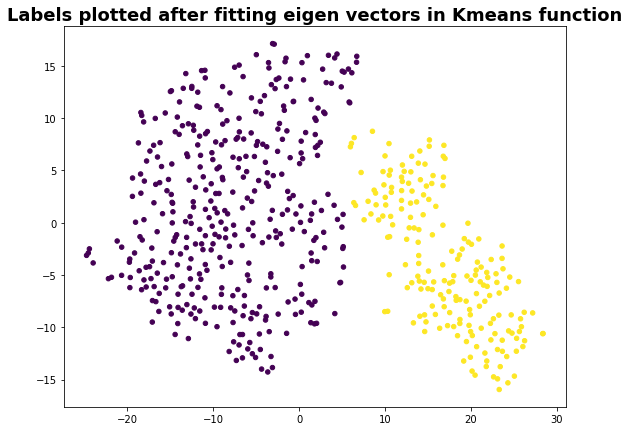

In [128]:
error_plot_nmi = []
error_plot_slt = []
for i in range(10):
  labels, centroids = my_kmeans(compute_eigen_vectors(Y),2)
  error_plot_nmi.append(normalized_mutual_info_score(datas['diagnosis'], labels))
  error_plot_slt.append(silhouette_score(Y, labels))

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Labels plotted after fitting eigen vectors in Kmeans function', fontsize=18, fontweight='demi')
ax.scatter(Y[:, 0], Y[:, 1],c=labels ,s=20)

[0.6604865332044598, 0.6604865332044597, 0.6604865332044597, 0.6604865332044598, 0.6604865332044598, 0.6604865332044597, 0.6604865332044597, 0.6604865332044598, 0.6604865332044597, 0.6604865332044597]
[0.513041, 0.513041, 0.513041, 0.513041, 0.513041, 0.513041, 0.513041, 0.513041, 0.513041, 0.513041]


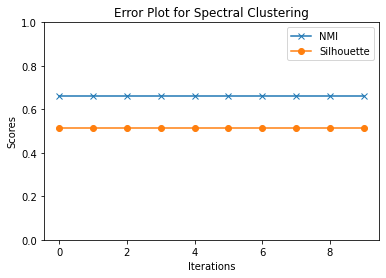

In [83]:
print(error_plot_nmi)
print(error_plot_slt)

fig, ax = plt.subplots()

ax.plot(range(0, 10), error_plot_nmi, marker='x', label='NMI')
ax.plot(range(0, 10), error_plot_slt, marker='o', label='Silhouette')

ax.set_xlabel('Iterations')
ax.set_ylabel('Scores')
ax.set_title('Error Plot for Spectral Clustering')
ax.set_ylim(0,1)
ax.legend()

plt.show()


In [68]:
nmi_score_sp = normalized_mutual_info_score(datas['diagnosis'], labels)
s_score_sp = silhouette_score(Y, labels)
print('Silhouette Score - ',s_score_sp)
print('NMI Score - ', nmi_score_sp)

Silhouette Score -  0.513041
NMI Score -  0.6604865332044597


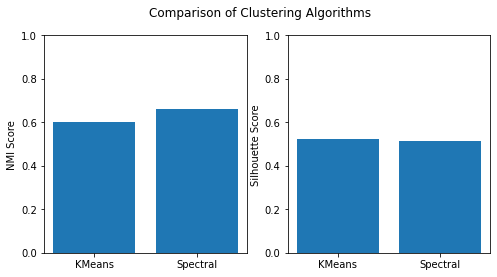

In [26]:
nmi_scores = [nmi_score_km, nmi_score_sp]
silhouette_scores = [s_score_km, s_score_sp]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# ploting NMI scores
ax1.bar(np.arange(len(nmi_scores)), nmi_scores)
ax1.set_xticks(np.arange(len(nmi_scores)))
ax1.set_xticklabels(['KMeans', 'Spectral'])
ax1.set_ylabel('NMI Score')
ax1.set_ylim([0, 1])

# plotting Silhouette scores
ax2.bar(np.arange(len(silhouette_scores)), silhouette_scores)
ax2.set_xticks(np.arange(len(silhouette_scores)))
ax2.set_xticklabels(['KMeans', 'Spectral'])
ax2.set_ylabel('Silhouette Score')
ax2.set_ylim([0, 1])

# adding title and show plot
fig.suptitle('Comparison of Clustering Algorithms')
plt.show()


### **Implementation Correctness Report**

In [85]:
data = pd.read_csv('implementation_correctness_dataset.csv')
data.head()

,Feature 1,Feature 2,Class/Cluster
0,0.020,0.0,1
1,1.045,0.0,1
2,2.080,0.0,1
3,3.125,0.0,1
4,4.180,0.0,1


In [62]:
datanew = data.iloc[:, :-1].values
datanew

array([[0.02      , 0.        ],
       [1.045     , 0.        ],
       [2.08      , 0.        ],
       [3.125     , 0.        ],
       [4.18      , 0.        ],
       [5.245     , 0.        ],
       [6.32      , 0.        ],
       [7.405     , 0.        ],
       [8.5       , 0.        ],
       [9.605     , 0.        ],
       [0.        , 1.005     ],
       [0.        , 2.04287094],
       [0.        , 3.15067663],
       [0.        , 4.36758347],
       [3.        , 1.62946271],
       [3.        , 2.26894388],
       [3.        , 2.92310397]])

In [64]:
labels, centroids = my_kmeans(datanew, 2)
print(labels)

[1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1]


K Means with custom Implementation

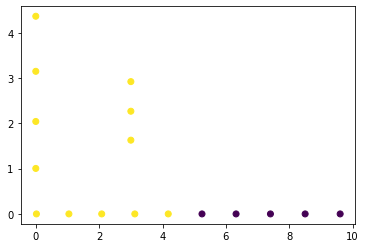

In [43]:
import matplotlib.pyplot as plt
plt.scatter(datanew[:,0], datanew[:,1], c=labels)
plt.show()

In [49]:
nmi_score_sp = normalized_mutual_info_score(data['Class/Cluster'], labels)
s_score_sp = silhouette_score(datanew, labels)
print('Silhouette Score - ',s_score_sp)
print('NMI Score - ', nmi_score_sp)

Silhouette Score -  0.5300117189896503
NMI Score -  0.1288617483267018


Spectral Clustering Custom Implementation

In [114]:
#1. Generating Adjacency Matrix

import numpy as np
from sklearn.neighbors import NearestNeighbors

N, d = datanew.shape

dist = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        dist[i,j] = np.linalg.norm(datanew[i] - datanew[j])
        dist[j,i] = dist[i,j]

k = 3
nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
nn.fit(datanew)
_, indices = nn.kneighbors(datanew)

adj_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        if i in indices[j] or j in indices[i]:
            adj_matrix[i,j] = adj_matrix[j,i] = 1

print(adj_matrix)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]


In [95]:
error_plot_nmi = []
error_plot_slt = []
for i in range(10):
  embeddings = compute_eigen_vectors(datanew)
  labelsic, centroidsic = my_kmeans(embeddings,2)
  error_plot_nmi.append(normalized_mutual_info_score(data['Class/Cluster'], labelsic))
  error_plot_slt.append(silhouette_score(datanew, labelsic))

In [107]:
print(embeddings)
print(labelsic)

[[-0.24253563  0.19095478]
 [-0.24253563  0.15620674]
 [-0.24253563  0.09361891]
 [-0.24253563  0.02598101]
 [-0.24253563 -0.05864059]
 [-0.24253563 -0.16618812]
 [-0.24253563 -0.27010071]
 [-0.24253563 -0.357609  ]
 [-0.24253563 -0.42152545]
 [-0.24253563 -0.46120255]
 [-0.24253563  0.2125787 ]
 [-0.24253563  0.24965678]
 [-0.24253563  0.28919668]
 [-0.24253563  0.3216502 ]
 [-0.24253563  0.05891701]
 [-0.24253563  0.0661269 ]
 [-0.24253563  0.07037869]]
[1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1]


[0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018, 0.1288617483267018]
[0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503, 0.5300117189896503]


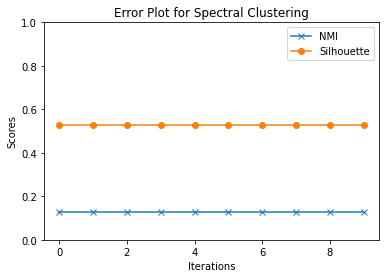

In [103]:
print(error_plot_nmi)
print(error_plot_slt)

fig, ax = plt.subplots()

ax.plot(range(0, 10), error_plot_nmi, marker='x', label='NMI')
ax.plot(range(0, 10), error_plot_slt, marker='o', label='Silhouette')

ax.set_xlabel('Iterations')
ax.set_ylabel('Scores')
ax.set_title('Error Plot for Spectral Clustering')
ax.set_ylim(0,1)
ax.legend()

plt.show()


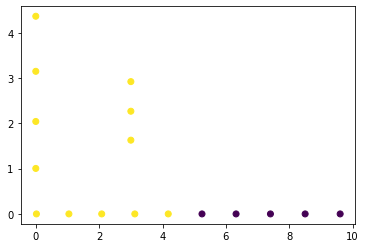

In [105]:
plt.scatter(datanew[:,0], datanew[:,1], c= labelsic)
plt.show()

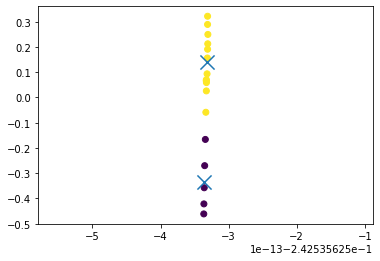

In [92]:
plt.scatter(embeddings[:,0], embeddings[:,1], c= labelsic)
plt.scatter(centroidsic[:,0], centroidsic[:,1],s=200, marker = 'x')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

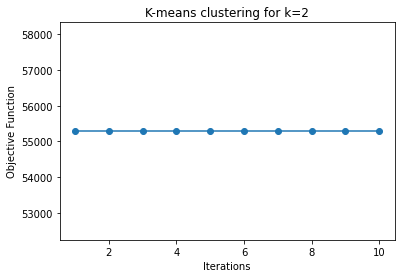

In [129]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=10, random_state=42)
objective_func = []
for i in range(10):
    kmeans.fit(Y)
    objective_func.append(kmeans.inertia_)
    if i < 9:
        kmeans.labels_ = np.zeros(len(X))

# plot objective function over iterations
plt.plot(range(1, 11), objective_func, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Objective Function')
plt.title('K-means clustering for k=2')
plt.show()
